In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_rules_of_tree_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
def get_predicted_rules(indices=None):
    indices = np.where(y_true)[0] if indices is None else indices
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    return pd.Series(pred_rule_nos, index=indices)

# Explanations

In [5]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'explanations/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 35min 30s, sys: 16.8 s, total: 35min 47s
Wall time: 38min 32s


## $(1,0)$

In [6]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [7]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

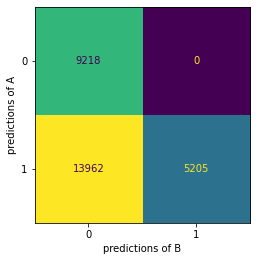

In [9]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/gaussian-diro2c-cf-10.pdf')

In [10]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 5.86 s, sys: 34.7 ms, total: 5.89 s
Wall time: 5.97 s


118

In [11]:
trees[-1].get_depth()

18

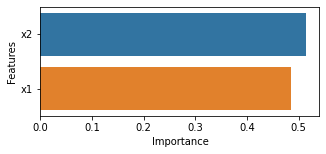

In [12]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

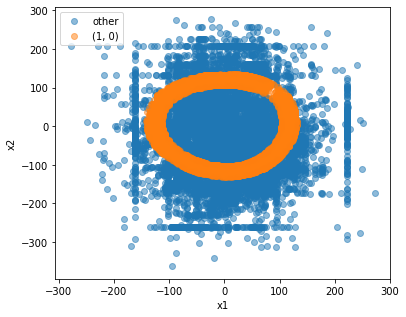

In [9]:
plot_diro2c_2d(explanation, 'x1', 'x2', class_names=class_names)
plt.savefig('figures/gaussian-diro2c-generated-data.png', bbox_inches='tight', pad_inches=0, dpi=300)

### 5 Leafs

In [14]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.05090219759710779, 4, 5)

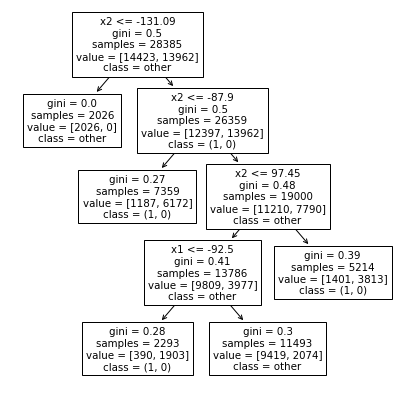

In [15]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [16]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -131.1 < x2 <= -87.9 => (0, 1) [1187, 6172]
2. x2 > 97.5 => (0, 1) [1401, 3813]
3. x1 <= -92.5 and -87.9 < x2 <= 97.5 => (0, 1) [390, 1903]


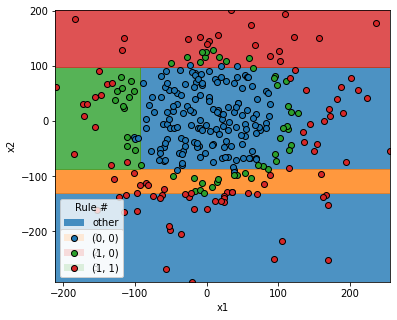

In [17]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 6 Leafs

In [18]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.047144262572533846, 5, 6)

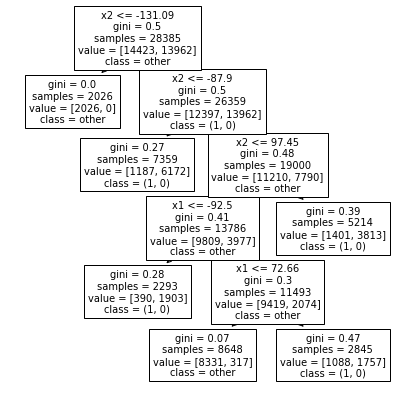

In [19]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [20]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -131.1 < x2 <= -87.9 => (0, 1) [1187, 6172]
2. x2 > 97.5 => (0, 1) [1401, 3813]
3. x1 > 72.7 and -87.9 < x2 <= 97.5 => (0, 1) [1088, 1757]
4. x1 <= -92.5 and -87.9 < x2 <= 97.5 => (0, 1) [390, 1903]


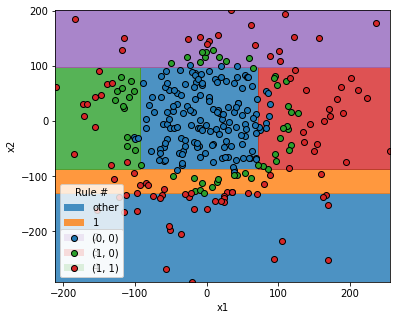

In [21]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 7 Leafs

In [22]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.028142064607212608, 5, 7)

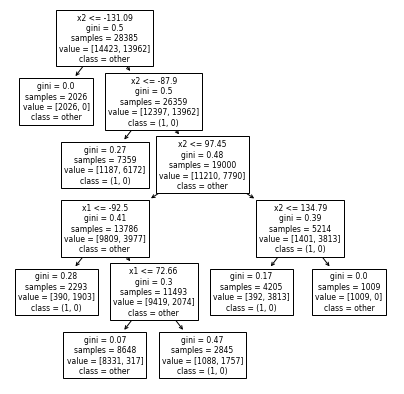

In [23]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [24]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -131.1 < x2 <= -87.9 => (0, 1) [1187, 6172]
2. 97.5 < x2 <= 134.8 => (0, 1) [392, 3813]
3. x1 > 72.7 and -87.9 < x2 <= 97.5 => (0, 1) [1088, 1757]
4. x1 <= -92.5 and -87.9 < x2 <= 97.5 => (0, 1) [390, 1903]


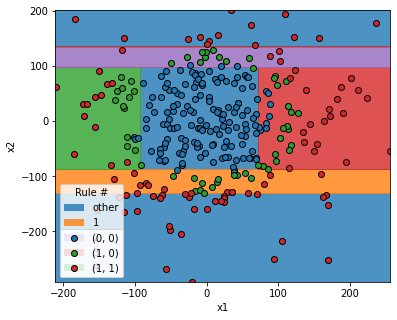

In [25]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 8 Leafs

In [26]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.015797170235556796, 5, 8)

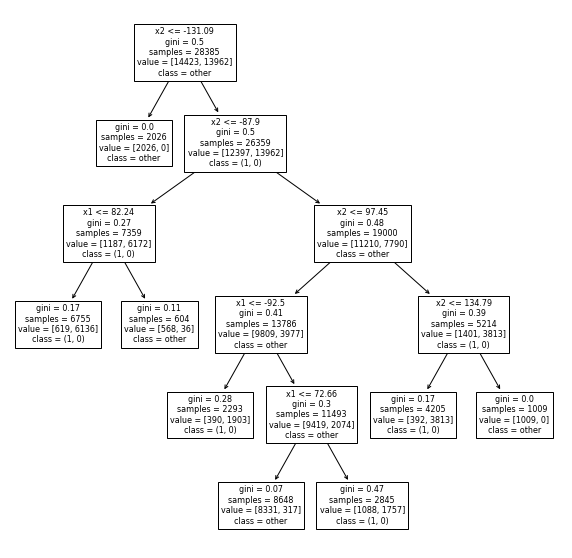

In [27]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(10, 10))

In [28]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 82.2 and -131.1 < x2 <= -87.9 => (0, 1) [619, 6136]
2. 97.5 < x2 <= 134.8 => (0, 1) [392, 3813]
3. x1 > 72.7 and -87.9 < x2 <= 97.5 => (0, 1) [1088, 1757]
4. x1 <= -92.5 and -87.9 < x2 <= 97.5 => (0, 1) [390, 1903]


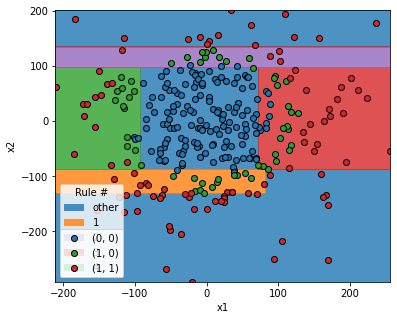

In [29]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 9 Leafs

In [30]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.014046559676262253, 5, 9)

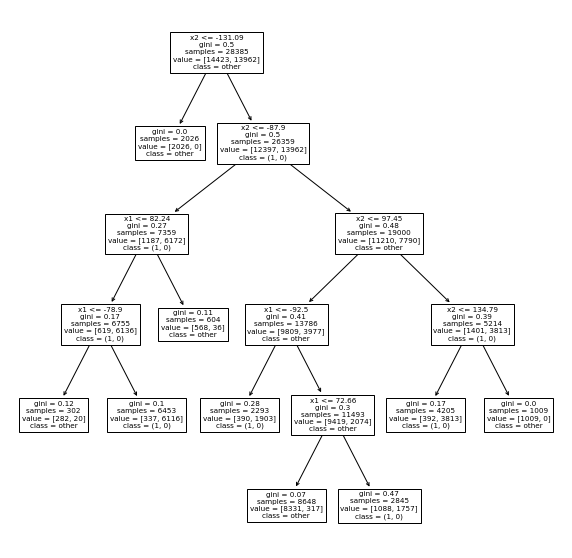

In [31]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(10, 10))

In [32]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -78.9 < x1 <= 82.2 and -131.1 < x2 <= -87.9 => (0, 1) [337, 6116]
2. 97.5 < x2 <= 134.8 => (0, 1) [392, 3813]
3. x1 > 72.7 and -87.9 < x2 <= 97.5 => (0, 1) [1088, 1757]
4. x1 <= -92.5 and -87.9 < x2 <= 97.5 => (0, 1) [390, 1903]


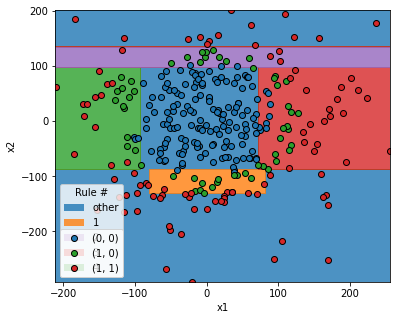

In [33]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 10 Leafs

In [34]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.011258845221568392, 5, 10)

In [35]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -78.9 < x1 <= 82.2 and -131.1 < x2 <= -87.9 => (0, 1) [337, 6116]
2. 97.5 < x2 <= 134.8 => (0, 1) [392, 3813]
3. x1 > 72.7 and -87.9 < x2 <= 97.5 => (0, 1) [1088, 1757]
4. -142.0 < x1 <= -92.5 and -87.9 < x2 <= 97.5 => (0, 1) [133, 1903]


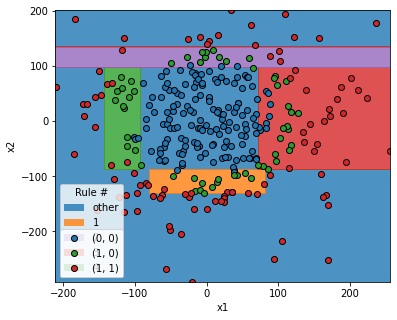

In [36]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 11 Leafs

In [37]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.008288018981693082, 6, 11)

In [38]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -78.9 < x1 <= 82.2 and -131.1 < x2 <= -87.9 => (0, 1) [337, 6116]
2. 97.5 < x2 <= 134.8 => (0, 1) [392, 3813]
3. 72.7 < x1 <= 131.3 and -87.9 < x2 <= 97.5 => (0, 1) [721, 1756]
4. -142.0 < x1 <= -92.5 and -87.9 < x2 <= 97.5 => (0, 1) [133, 1903]


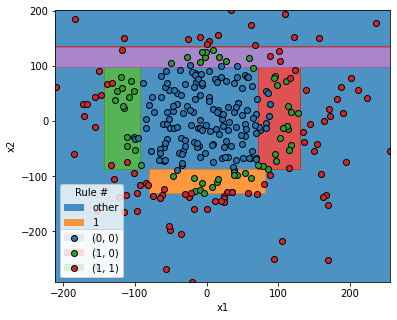

In [39]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 13 Leafs

In [40]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.004910902027399646, 8, 13)

In [41]:
constraints,rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -78.9 < x1 <= 82.2 and -131.1 < x2 <= -87.9 => (0, 1) [337, 6116]
2. 97.5 < x2 <= 134.8 => (0, 1) [392, 3813]
3. -142.0 < x1 <= -92.5 and -87.9 < x2 <= 97.5 => (0, 1) [133, 1903]
4. 96.6 < x1 <= 131.3 and -87.9 < x2 <= 97.5 => (0, 1) [172, 1219]
5. 72.7 < x1 <= 96.6 and -87.9 < x2 <= -37.9 => (0, 1) [128, 513]


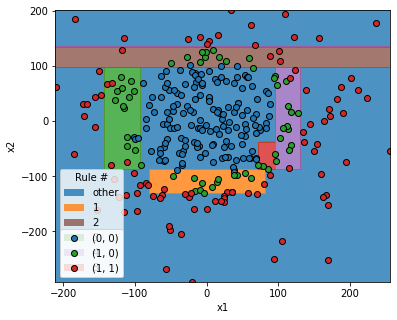

In [42]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)
plt.savefig('figures/gaussian-diro2c-final.pdf', bbox_inches='tight', pad_inches=0)

In [43]:
pred_rules = get_predicted_rules()
indices_not_explained = pred_rules.index[pd.isna(pred_rules)].tolist()
indices_not_explained

[155, 169, 203, 214, 252]

In [44]:
indices = indices_not_explained
for level, tree in enumerate(trees):
    constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    if all([no != None for no in pred_rule_nos]):
        print(level)
        break

20


In [45]:
tree = trees[20]
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0008614004356027798, 12, 47)

In [46]:
constraints,rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -78.9 < x1 <= 71.9 and -120.5 < x2 <= -95.3 => (0, 1) [84, 4780]
2. x1 <= 91.5 and 97.5 < x2 <= 129.0 => (0, 1) [97, 3168]
3. -142.0 < x1 <= -107.1 and -87.9 < x2 <= 97.5 => (0, 1) [34, 1705]
4. 102.2 < x1 <= 124.9 and -50.1 < x2 <= 97.5 => (0, 1) [14, 863]
5. -34.9 < x1 <= 47.7 and 129.0 < x2 <= 134.8 => (0, 1) [16, 629]
6. -78.9 < x1 <= -35.4 and -95.3 < x2 <= -87.9 => (0, 1) [2, 414]
7. 72.7 < x1 <= 96.6 and -87.9 < x2 <= -64.4 => (0, 1) [15, 378]
8. -42.1 < x1 <= 48.5 and -131.1 < x2 <= -120.5 => (0, 1) [15, 367]
9. 41.9 < x1 <= 82.2 and -95.3 < x2 <= -87.9 => (0, 1) [0, 317]
10. 71.9 < x1 <= 82.2 and -108.0 < x2 <= -95.3 => (0, 1) [8, 235]
11. 96.6 < x1 <= 102.2 and -81.4 < x2 <= -18.6 => (0, 1) [0, 155]
12. 79.1 < x1 <= 96.6 and -64.4 < x2 <= -37.9 => (0, 1) [18, 134]
13. -107.1 < x1 <= -92.5 and -87.9 < x2 <= -33.4 => (0, 1) [2, 150]
14. 55.0 < x1 <= 72.7 and -87.9 < x2 <= -74.4 => (0, 1) [4, 104]
15. 124.9 < x1 <= 131.3 and -24.7 < x2 <= 97.5 => (0, 1) [7, 94]
16. -92.5 < x1

In [47]:
get_predicted_rules(indices_not_explained)

155    21
169    16
203    23
214    21
252    14
dtype: int64

In [48]:
get_complexity(constraints)

Rules          23
Constraints    91
dtype: int64

# Evaluation

In [6]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [7]:
explanations_per_class = {}
for class_name in comparer.class_names:
    with open(f'explanations/diro2c.{class_name}.pickle', 'rb') as f:
        explanations_per_class[class_name] = pickle.load(f)

In [8]:
metrics = eval_diro2c(explanations_per_class, X_test, y_test, comparer.class_names)
metrics

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.627593,0.977608,0.764440,4332.0,"(0, 0)",3.0,0.114107,1.0,2.0
1,0.717272,0.966297,0.823367,4332.0,"(0, 0)",4.0,0.051891,1.0,3.0
1,0.912957,0.956371,0.934160,4332.0,"(0, 0)",5.0,0.012029,1.0,4.0
1,0.912957,0.956371,0.934160,4332.0,"(0, 0)",6.0,0.009573,2.0,8.0
1,0.943784,0.953370,0.948553,4332.0,"(0, 0)",8.0,0.005482,2.0,8.0
...,...,...,...,...,...,...,...,...,...
1,0.984022,0.992561,0.988273,4033.0,"(1, 1)",153.0,0.000025,86.0,327.0
1,0.984256,0.992065,0.988145,4033.0,"(1, 1)",157.0,0.000024,88.0,335.0
1,0.984260,0.992313,0.988270,4033.0,"(1, 1)",159.0,0.000014,89.0,339.0
1,0.984256,0.992065,0.988145,4033.0,"(1, 1)",163.0,0.000014,92.0,347.0


In [9]:
metrics.loc[(metrics['Leafs'] == 13) & (metrics['Label'] == '(1, 0)'), :]

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.583773,0.880122,0.701951,1635.0,"(1, 0)",13.0,0.004911,5.0,18.0


<AxesSubplot:xlabel='Constraints', ylabel='F1 Score'>

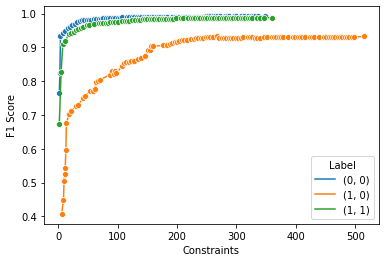

In [10]:
sns.lineplot(data=metrics, x='Constraints', y='F1 Score', hue='Label', marker='o')

In [11]:
with open('data/fidelity-diro2c.pickle', 'wb') as f:
    pickle.dump(metrics, f)

# Further Material

In [74]:
tree = trees[7]
tree.get_n_leaves()

13

In [75]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions, latex=True)
for rule in rules:
    print(f'\item if ${rule}$, then $(1, 0)$')

\item if $-78.9 < \mathit{x_1} \leq 82.2 \land -131.1 < \mathit{x_2} \leq -87.9$, then $(1, 0)$
\item if $97.5 < \mathit{x_2} \leq 134.8$, then $(1, 0)$
\item if $-142.0 < \mathit{x_1} \leq -92.5 \land -87.9 < \mathit{x_2} \leq 97.5$, then $(1, 0)$
\item if $96.6 < \mathit{x_1} \leq 131.3 \land -87.9 < \mathit{x_2} \leq 97.5$, then $(1, 0)$
\item if $72.7 < \mathit{x_1} \leq 96.6 \land -87.9 < \mathit{x_2} \leq -37.9$, then $(1, 0)$


(0.0006681363253562564, 12, 54)

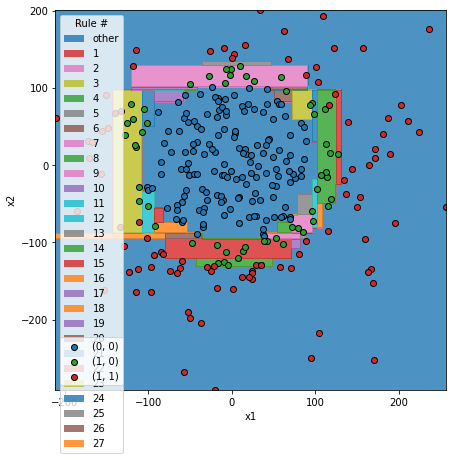

In [77]:
tree = trees[24]
constraints,rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

In [78]:
get_complexity(constraints)

Rules           27
Constraints    107
dtype: int64